# Multilayer perceptron

Pytorch framework documentation [here](https://pytorch.org/)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

#import time
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical

import torch
import torch.nn as nn
from torchsummary import summary

## Load data - [MNIST](http://yann.lecun.com/exdb/mnist/)

In [2]:
# Load MNIST data
train_data = pd.read_csv( "/content/sample_data/mnist_train_small.csv"  , header=None)
test_data = pd.read_csv( "/content/sample_data/mnist_test.csv"  , header=None)

X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values

X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(20000, 784) (20000,) (10000, 784) (10000,)


In [3]:
# create train / test splits
#X_train, X_test, y_train, y_test = _

# Reshape to bidimensional (image) size
#X_train, X_test = _ , _

#print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

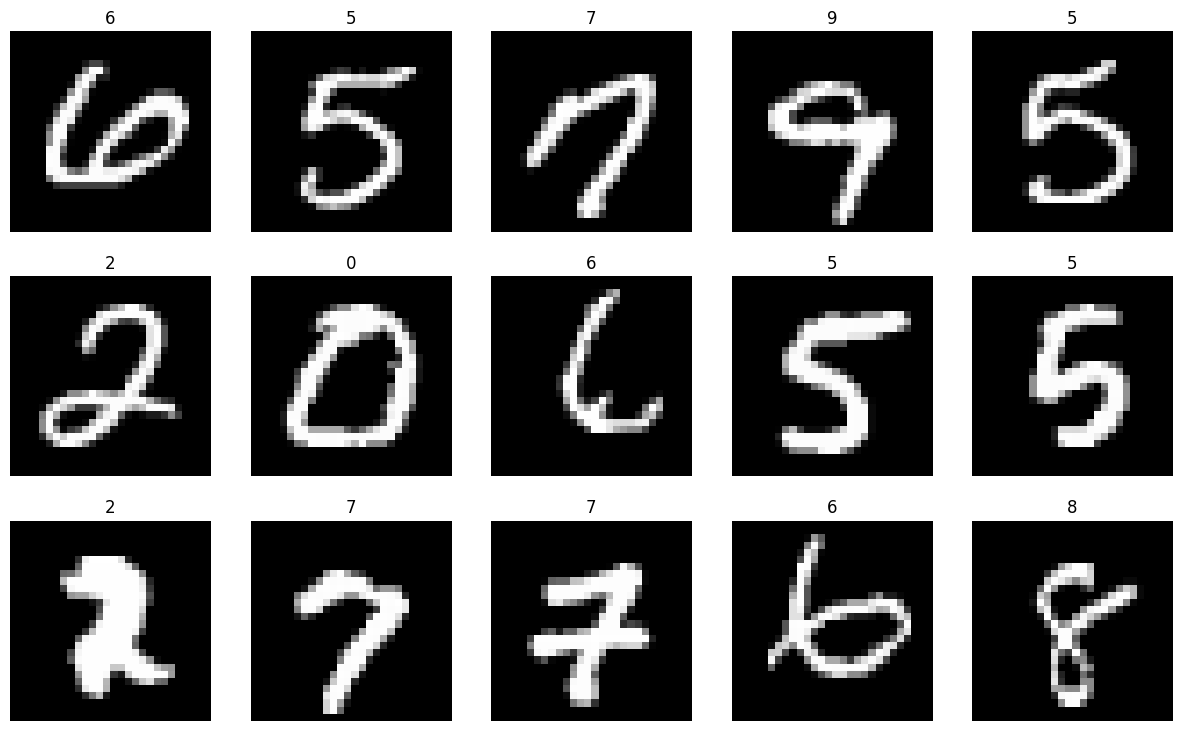

In [4]:
# Visualize grid of samples
grid_size = (3, 5)

_, axes = plt.subplots ( grid_size[0] , grid_size[1] , figsize=(grid_size[1]*3, grid_size[0]*3))
axes = axes.ravel()

for i, ax in enumerate(axes):
  ax.imshow( X_train[i].reshape([28, 28]), cmap='gray')
  ax.set_title(str(y_train[i]))
  ax.set_axis_off()


In [5]:
# Reshape the data - MLPs do not understand such '2D' stuff
# Reshape to 1D is similat to "flatten" an image

# Configuration options
feature_vector_length = 784
num_classes = 10

# Convert into 0 - 1 values
X_train = X_train / (X_train.max() - X_train.min())
X_test = X_test / (X_test.max() - X_test.min())

print (X_train.min(), X_train.max())
print (X_test.min(), X_test.max())

0.0 1.0
0.0 1.0


In [6]:
# Convert target classes to categorical ones - one hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [7]:
print (X_train.shape, y_train.shape)

(20000, 784) (20000, 10)


## Create a graph model

In [8]:
model = torch.nn.Sequential(
  nn.Linear( feature_vector_length, 512 ), nn.ReLU(),
  nn.Linear( 512 , 256 ), nn.ReLU(),
  nn.Linear( 256 , 128 ), nn.ReLU(),
  nn.Linear( 128 , 64 ), nn.ReLU(),
  nn.Linear( 64 , 32 ), nn.ReLU(),
  nn.Linear( 32 , 16 ), nn.ReLU(),
  nn.Linear( 16 , num_classes ), nn.Softmax()
)

summary(model, input_size=(feature_vector_length,), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 256]         131,328
              ReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
              ReLU-6                  [-1, 128]               0
            Linear-7                   [-1, 64]           8,256
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 32]           2,080
             ReLU-10                   [-1, 32]               0
           Linear-11                   [-1, 16]             528
             ReLU-12                   [-1, 16]               0
           Linear-13                   [-1, 10]             170
          Softmax-14                   

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1845: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return inner()


## Define loss function and optimizer

In [9]:
loss = nn.CrossEntropyLoss() # nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3) # torch.optim.SGD(model.parameters(), lr = 1e-1)

## Train model

In [10]:
# Model params for training
epochs = 100
batch_size = 200 # We dont train the whole dataset at the time
losses = []

progress = tqdm(range(epochs), ncols=100);

for epoch in progress : # Iterate over all the num of epochs

  batch_losses = 0

  for batch_i in range(0, len(X_train), batch_size) : # Iterate over all batches of data

    # First step, take the data from the dataset
    batch_X = X_train[ batch_i : batch_i + batch_size ]
    batch_y = y_train[ batch_i : batch_i + batch_size ]
    batch_X = torch.from_numpy(batch_X).to(torch.float32) # Convert to torch tensor to feed the graph
    batch_y = torch.from_numpy(batch_y).to(torch.float32) # Convert to torch tensor to feed the graph

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    predictions = model(batch_X)

    # Compute loss
    batch_loss = loss(predictions, batch_y)

    # Perform backward pass
    batch_loss.backward()

    # Optimize parameters
    optimizer.step()

    ## Accumulate loss to compute mean over all batches
    batch_losses += batch_loss.item()

  epoch_loss = batch_losses / (len(X_train) / batch_size)

  # Compute time and show all progress
  progress.set_description("[Epoch %d/%d] [Loss: %f]" % (epoch, epochs, epoch_loss))

  # Save epoch loss
  losses.append(batch_losses/(len(X_train)/batch_size));


  0%|                                                                       | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
[Epoch 99/100] [Loss: 1.473553]: 100%|████████████████████████████| 100/100 [05:10<00:00,  3.10s/it]


## Plot results

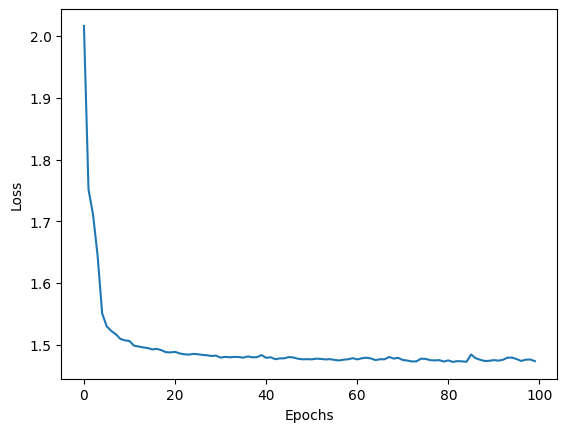

In [11]:
# Plot progress (loss function)
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Compute metrics over ```X_test``` images

In [12]:
progress = tqdm(range( 0 , len(X_test) , batch_size ), ncols=100);
predictions = []

for batch_i in progress : # Iterate over all batches of data

  batch_X = X_test[ batch_i : batch_i + batch_size ]
  batch_y = y_test[ batch_i : batch_i + batch_size ]
  batch_X = torch.from_numpy(batch_X).to(torch.float32)
  batch_y = torch.from_numpy(batch_y).to(torch.float32)

  # Perform forward pass to compute predictions
  batch_predictions = model(batch_X)
  predictions.extend(batch_predictions.detach().numpy())

print ('\n\n', len(predictions));

100%|██████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 158.69it/s]



 10000


acc: 0.9597


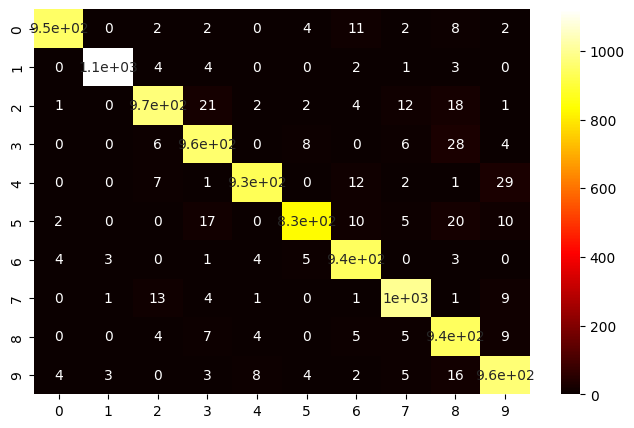

In [13]:
y_test_ = np.argmax(y_test, axis=1)
predictions = np.argmax(predictions, axis=1)
acc = accuracy_score(y_test_, predictions)
cm_ = confusion_matrix(y_test_, predictions)

# Compute confusion matrix and accuracy
_, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cm_, cmap="hot", annot=True, ax=ax)
print("acc: {0}".format(acc))